# Spaceship Titanic II

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

### Читаем данные

In [2]:
df = pd.read_csv('train_new.csv')

ce_encoder = ce.CountEncoder()
df_num = ce_encoder.fit_transform(df)

### Видим что возраст и родная планета - безусловно важные фичи

<Axes: xlabel='HomePlanet', ylabel='Age'>

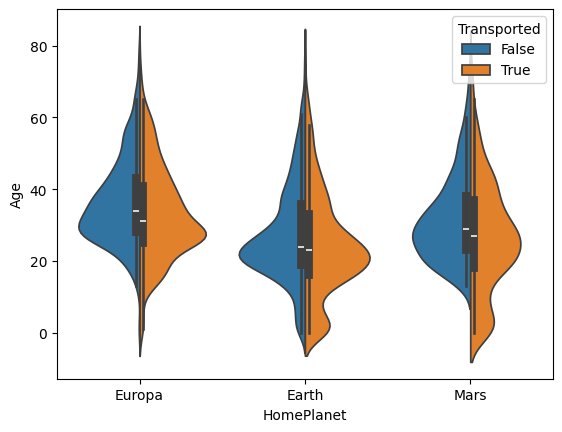

In [3]:
cols = list(df.columns)
sns.violinplot(x=cols[1], y='Age', hue='Transported', data=df, split=True)

### CryoSleep - один из наиболее важных признаков

<Axes: xlabel='CryoSleep', ylabel='Transported'>

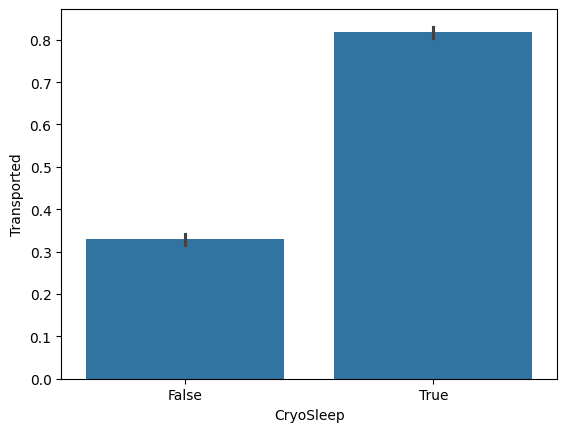

In [4]:
sns.barplot(x=cols[2], y='Transported', data=df)

### Влияние пукта назначения мало, но тем не менее имеется

<Axes: xlabel='Destination', ylabel='Age'>

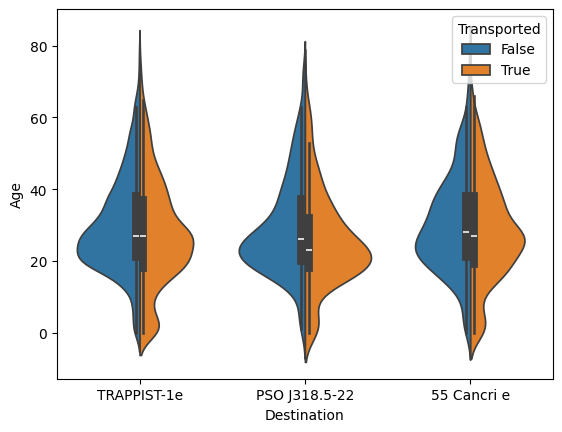

In [5]:
sns.violinplot(x=cols[3], y='Age', hue='Transported', data=df, split=True)

### VIP дает немного информации о целевой фиче

<Axes: xlabel='VIP', ylabel='Transported'>

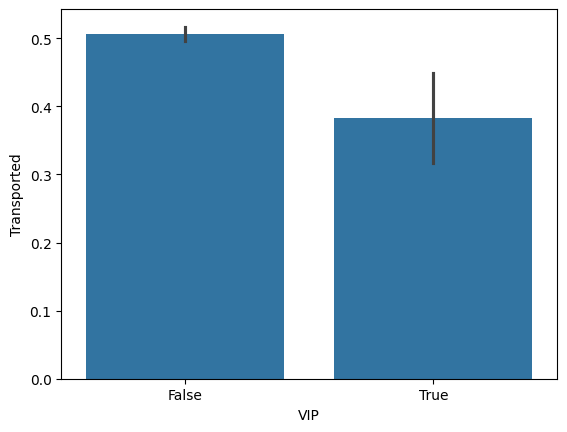

In [6]:
sns.barplot(x='VIP', y='Transported', data=df)

### Видим что за исключением малой части записей (прим. - палуба G номера ~1000) палуба и номер каюты не влияют на цель

<Axes: xlabel='Deck', ylabel='NumCabin'>

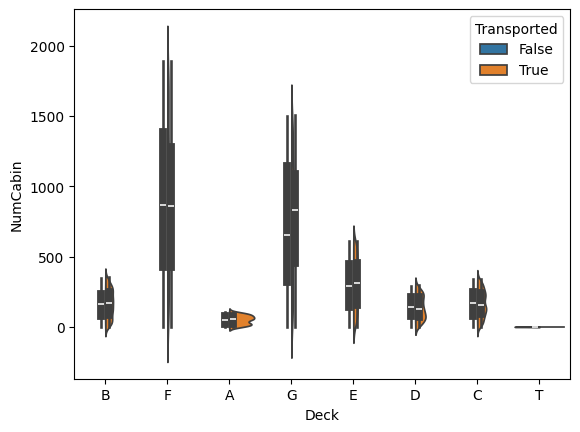

In [7]:
sns.violinplot(x=cols[11], y=cols[12], hue='Transported', data=df, split=True)

### Side - признак дающий немного информации о целевой фиче

<Axes: xlabel='Side', ylabel='Transported'>

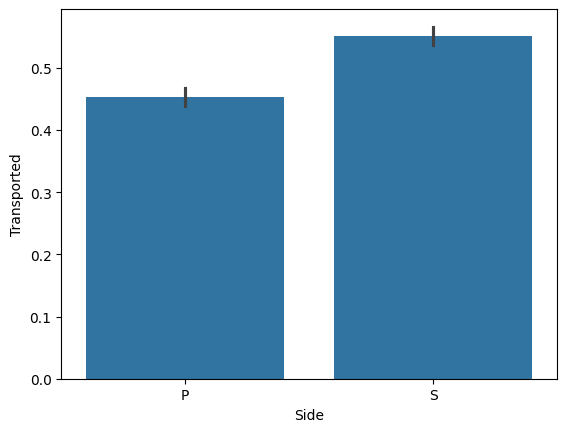

In [8]:
sns.barplot(x='Side', y='Transported', data=df)

### Из-за неустраняемых выбросов сложно судить о важности RoomService, FoodCourt ShoppingMall, Spa, VRDeck (почти для всех записей значения нулевые). Тем не менее, опираясь на данные о корреляции можно сделать вывод, что Spa, VRDeck и RoomService полезны, а FoodCourt и ShoppingMall менее существенны

<Axes: xlabel='HomePlanet', ylabel='RoomService'>

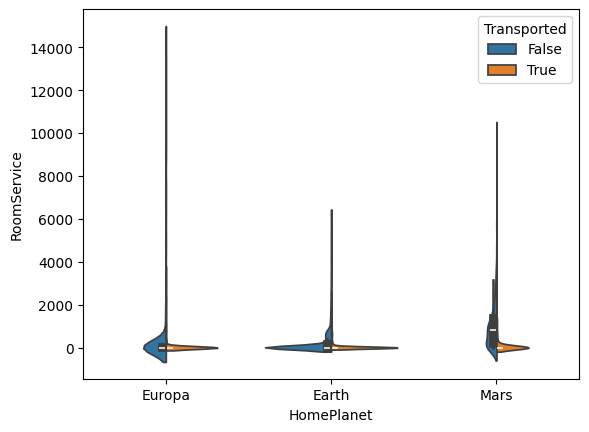

In [9]:
sns.violinplot(x=cols[1], y=cols[6], hue='Transported', data=df, split=True)

## 28/10/2023

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476 entries, 0 to 8475
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Transported   8476 non-null   bool   
 1   HomePlanet    8476 non-null   object 
 2   CryoSleep     8476 non-null   bool   
 3   Destination   8476 non-null   object 
 4   Age           8476 non-null   float64
 5   VIP           8476 non-null   bool   
 6   RoomService   8476 non-null   float64
 7   FoodCourt     8476 non-null   float64
 8   ShoppingMall  8476 non-null   float64
 9   Spa           8476 non-null   float64
 10  VRDeck        8476 non-null   float64
 11  Deck          8476 non-null   object 
 12  NumCabin      8476 non-null   int64  
 13  Side          8476 non-null   object 
dtypes: bool(3), float64(6), int64(1), object(4)
memory usage: 753.4+ KB


In [11]:
df_num['CryoSleep'] = df_num['CryoSleep'].astype(bool)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476 entries, 0 to 8475
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Transported   8476 non-null   bool   
 1   HomePlanet    8476 non-null   int64  
 2   CryoSleep     8476 non-null   bool   
 3   Destination   8476 non-null   int64  
 4   Age           8476 non-null   float64
 5   VIP           8476 non-null   bool   
 6   RoomService   8476 non-null   float64
 7   FoodCourt     8476 non-null   float64
 8   ShoppingMall  8476 non-null   float64
 9   Spa           8476 non-null   float64
 10  VRDeck        8476 non-null   float64
 11  Deck          8476 non-null   int64  
 12  NumCabin      8476 non-null   int64  
 13  Side          8476 non-null   int64  
dtypes: bool(3), float64(6), int64(5)
memory usage: 753.4 KB


In [12]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
import pickle

df_acc = _
def feature_importances(dataframe):
    global df_acc
    target = 'Transported'
    features = list(dataframe.columns)
    features.remove(target)
    X = dataframe[features]
    y = dataframe[['Transported']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    # Random Forest
    clf_rf = RandomForestClassifier(random_state = 0)
    clf_rf.fit(X_train, y_train)
    coef_rf = clf_rf.feature_importances_
    
    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))
    label_rf = f'Importance (LR abs), acc_train = {acc_train_rf:.2%}, acc_test = {acc_test_rf:.2%}'

    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'RF': coef_rf,
    })
    
    sc = MaxAbsScaler()
    feature_importance[['RF']] = sc.fit_transform(feature_importance[['RF']])
    
    # Plot everything
    
    feature_importance.plot(kind='bar', x='Feature')
    
    d = {
        'TrainAcc': [acc_train_rf],
        'TestAcc': [acc_test_rf]
    }
    df_acc = pd.DataFrame(data=d)
    df_acc.plot.bar()
    
    filename = 'model_rf.sav'
    pickle.dump(clf_rf, open(filename, 'wb'))
    
#     ax = plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (LR abs)'], label = label_lr)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (RF)'], label = label_rf, axes=ax)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (Cat)'], label = label_cat, axes=ax)
#     plt.show()

C:\ProgramData\anaconda3\envs\space_titanic\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


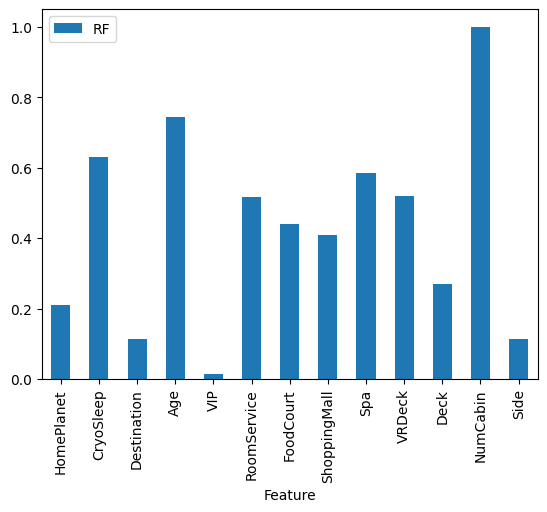

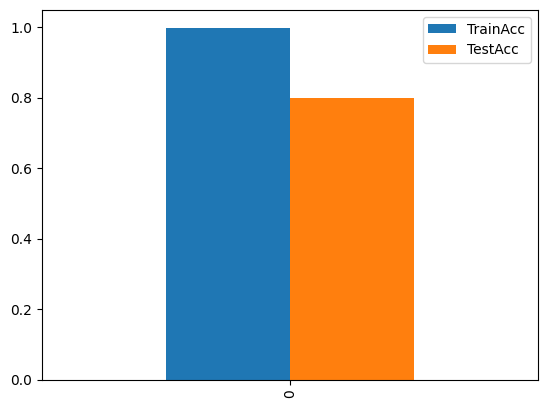

In [13]:
feature_importances(df_num)

In [14]:
from copy import deepcopy
df_new = deepcopy(df_num)
df_new.columns

Index(['Transported', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck',
       'NumCabin', 'Side'],
      dtype='object')

In [15]:
df_new = df_new.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1)

C:\ProgramData\anaconda3\envs\space_titanic\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


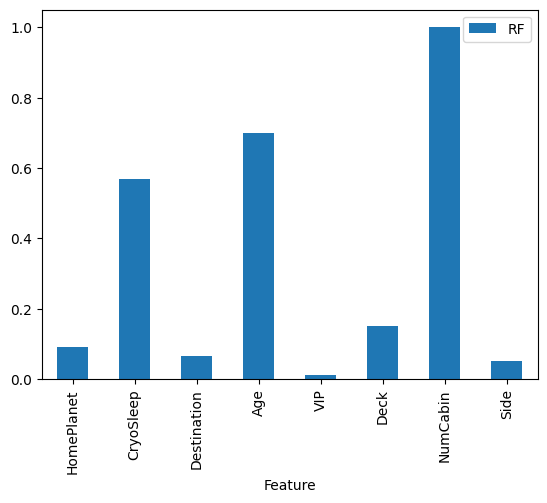

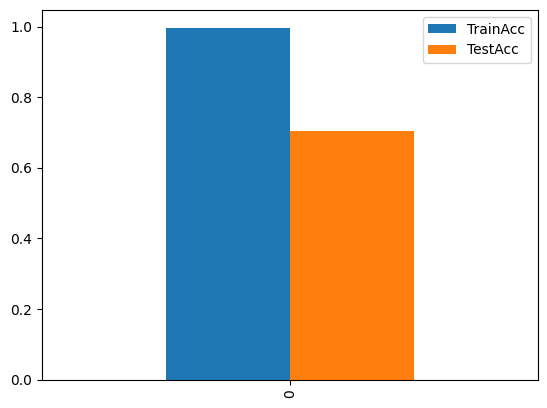

In [16]:
feature_importances(df_new)

In [17]:
df_acc

,TrainAcc,TestAcc
0,0.997955,0.705993


In [18]:
df_acc.to_csv('results_rf.csv', index=False)